In [1]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import gzip
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import pickle
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12

In [3]:
os.chdir('../')

In [4]:
with gzip.open('datasets/simulation/haematopoiesis/character_matrix.csv.gz', 'rb') as f:
    charater_matrix = pd.read_csv(f, index_col=0)
charater_matrix = charater_matrix.to_numpy()
with gzip.open('datasets/simulation/haematopoiesis/simulation_data.csv.gz', 'rb') as f:
    ground_truth = pd.read_csv(f, index_col=0)
ground_truth = ground_truth.to_numpy()
ground_truth = ground_truth[np.arange(0, ground_truth.shape[0], 1000)]
time = ground_truth[:, 0]
cell_number = ground_truth[:, 1:]

In [5]:
mutnum = spx.data_factory.get_mutnum(charater_matrix)
branch_len = spx.data_factory.get_branchlen(charater_matrix)

100%|██████████| 125250/125250 [00:05<00:00, 23868.28it/s]


In [16]:
idata_bl = spx.est_mr.mutation_rate_mcmc(branch_len, draw=500, tune=500)

Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 278 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
ge = spx.est_mr.GenerationEst(mutnum, 2)
gen_num = ge.estimate(cell_number[-1].sum())

In [8]:
res_de = spx.est_haem.para_inference_DE(gen_num, T=35, c0=100)

iter0, loss:[11380741.83125938], est=[0.20851528 0.61434591 2.73540588 3.44478499 9.60088326 0.31619957
iter1, loss:[3845191.51335025], est=[ 0.70889157  0.48936151  1.28272989  3.54873018 18.68657397  0.52306364
iter2, loss:[3845191.51335025], est=[ 0.70889157  0.48936151  1.28272989  3.54873018 18.68657397  0.52306364
iter3, loss:[3845191.51335025], est=[ 0.70889157  0.48936151  1.28272989  3.54873018 18.68657397  0.52306364
iter4, loss:[919672.4081212], est=[0.80484485 0.61182288 0.35820857 3.27284501 9.7529452  0.88311388
iter5, loss:[919672.4081212], est=[0.80484485 0.61182288 0.35820857 3.27284501 9.7529452  0.88311388
iter6, loss:[363886.41395328], est=[0.48936881 0.82876151 1.64886162 3.36645456 9.99759866 0.36903389
iter7, loss:[363886.41395328], est=[0.48936881 0.82876151 1.64886162 3.36645456 9.99759866 0.36903389
iter8, loss:[363886.41395328], est=[0.48936881 0.82876151 1.64886162 3.36645456 9.99759866 0.36903389
iter9, loss:[363886.41395328], est=[0.48936881 0.82876151 1.6

Text(0, 0.5, 'loss')

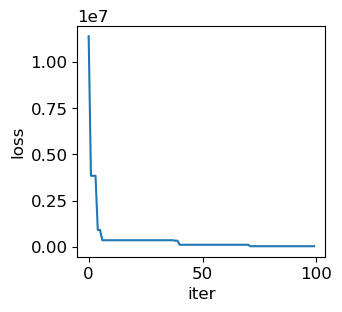

In [12]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.plot(np.array(res_de[1]).flatten())
ax.set_xlabel('iter')
ax.set_ylabel('loss')

In [13]:
axh, bxh, rh, kh, t0h, r1h, b1h = res_de[0][-1]
mcmc_prior = (axh, bxh, rh, kh, t0h, r1h, b1h)

In [13]:
mcmc_prior = (ast,bst,r,k,t0,r1,b1)

In [14]:
idata = spx.est_haem.mcmc_inference(gen_num, mcmc_prior, T=35, c0=100, sigma=100)

Population sampling (9 chains)
DEMetropolis: [ax, bx, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 1044 seconds.
/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 0, 'step')

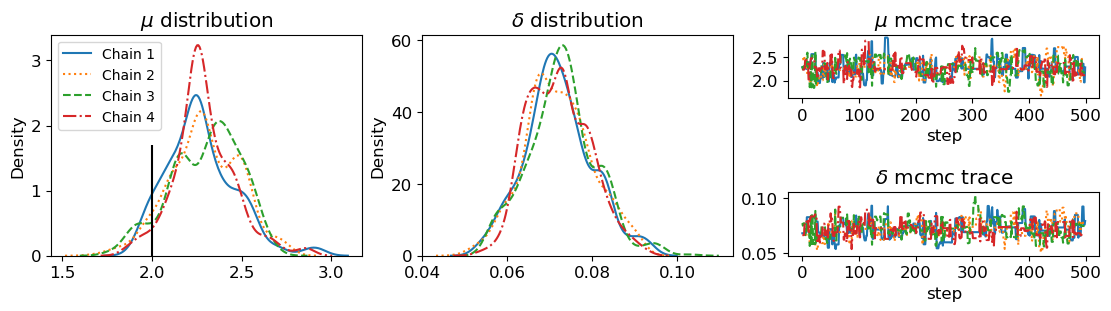

In [17]:
fig = plt.figure(layout='constrained',figsize=(11,3))
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:,0])
ls = 'solid,dotted,dashed,dashdot'.split(',')
for i, l in enumerate(ls):   
    sns.kdeplot(idata_bl.posterior['mu'].to_numpy()[i], linestyle=l, ax=ax1, label=f'Chain {i+1}')
ax1.vlines(2, 0, 1.7, color='black')
ax1.legend(fontsize=10,loc=2)
ax1.set_title(r'$\mu$ distribution')

ax2 = fig.add_subplot(gs[:,1])
for i, l in enumerate(ls):  
    sns.kdeplot(idata_bl.posterior['delta'].to_numpy()[i], linestyle=l, ax=ax2, label=f'Chain {i+1}')
ax2.set_title(r'$\delta$ distribution')
ax3 = fig.add_subplot(gs[0,2])
for i, l in enumerate(ls):
    ax3.plot(idata_bl.posterior['mu'][i], linestyle=l, label=f'Chain {i+1}')
ax3.set_title('$\mu$ mcmc trace')
ax3.set_xlabel('step')
ax4 = fig.add_subplot(gs[1,2])
for i, l in enumerate(ls):
    ax4.plot(idata_bl.posterior['delta'][i], linestyle=l, label=f'Chain {i+1}')
ax4.set_title(r'$\delta$ mcmc trace')
ax4.set_xlabel('step')

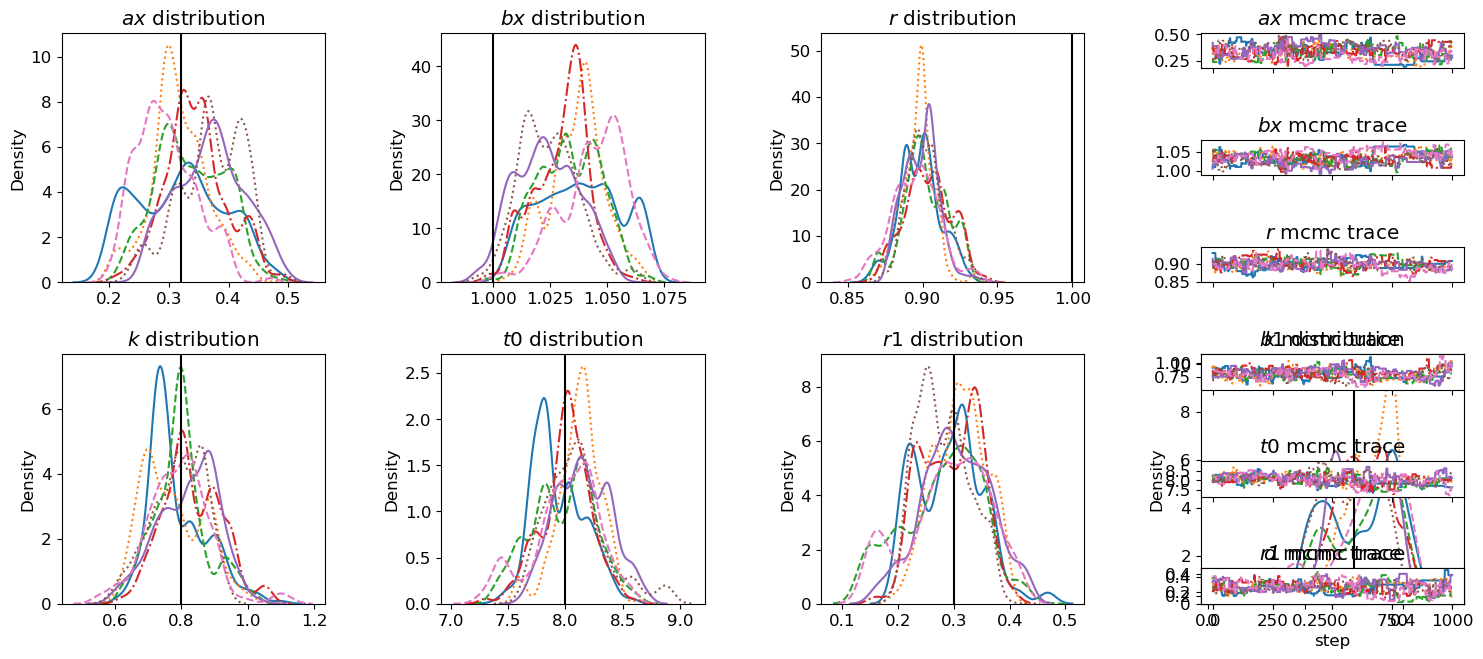

In [24]:
fig = plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = 12
gt = [ast,bst,r,k,t0,r1,b1]
gs = GridSpec(6, 4, figure=fig)
ls = 'solid.dotted.dashed.dashdot.solid.dotted.dashed'.split('.')
for ind, sym in enumerate('ax,bx,r,k,t0,r1,b1'.split(',')):
    if ind >= 3:
        ax = fig.add_subplot(gs[3:, ind-3])
    else:
        ax = fig.add_subplot(gs[:3, ind])
    for i, l in enumerate(ls):   
        sns.kdeplot(idata.posterior[sym].to_numpy()[i], linestyle=l, ax=ax, label=f'Chain {i+1}')
    # ax1.legend(fontsize=10,loc=2)
    ylim = ax.get_ylim()
    ax.vlines(gt[ind], *ylim, color='black')
    ax.set_ylim(ylim)
    ax.set_title(fr'${sym}$ distribution')

ax0 = fig.add_subplot(gs[-1, 3])
for i, l in enumerate(ls): 
    ax0.plot(idata.posterior['b1'][i], linestyle=l, label=f'Chain {i+1}')
    ax0.set_title(fr'$d$ mcmc trace')
for ind, sym in enumerate('ax,bx,r,k,t0,r1'.split(',')):
    ax = fig.add_subplot(gs[ind, 3], sharex=ax0)
    for i, l in enumerate(ls): 
        ax.plot(idata.posterior[sym][i], linestyle=l, label=f'Chain {i+1}')
        ax.set_title(fr'${sym}$ mcmc trace')
    plt.setp(ax.get_xticklabels(), visible=False)
ax0.set_xlabel('step')
plt.tight_layout()